# 臺灣 YouTube 頻道策略分析與優化（Python）


## 0.目錄
1. 專案概述
2. 資料來源
3. 工具使用
4. 套件載入
5. 資料收集<br>
  5-1 載入 YOUTUBE API KEY<br>
  5-2 取得 channelId<br>
  5-3 Channel<br>
  5-4 Playlist<br>
  5-5 Video<br>
  5-6 VideoCategory<br>
  5-7 Comment<br>
6. 資料合併
7. 資料探索及清洗
8. 資料分析<br>
  8-1 頻道總訂閱數，總影片數，總觀看數<br>
  8-2 每月平均觀看數<br>
  8-3 觀眾互動程度<br>
  8-4 每月發布影片數及影片平均長度<br>
  8-5 影片發布時間<br>
  8-6 影片最常設定的標籤（Tags）<br>
  8-7 觀看數最多的影片標題<br>
  8-8 影片標題及影片說明的字數 & 標籤使用數量<br>
9. 結論
10. 建議
11. 參考資料



## 1.專案概述

為了解臺灣知名 Youtube 頻道（包含Joeman，木曜4超玩，志祺七七X圖文不符，Dcard Video，Men's Game 玩物誌）經營 YT 的相關策略及表現，因此透過 YouTube Data API 取得所需資料，並使用 Google Colab Notebook 分析頻道訂閱數，影片數，觀看數，觀眾互動程度，影片發布策略，影片文字設定策略等，以了解各頻道間的差異，並提供相關決策建議，期望提升影片點擊率及吸引目標用戶。



## 2.資料來源

* 資料來源：[YouTube Data API](https://developers.google.com/youtube/v3/getting-started?hl=zh-tw)
* 資料期間：由各頻道成立起至2024年4月27日（後續分析會排除上傳時間在2024年3月31日之後的影片，而在2024年4月1日之前上傳的影片皆會統計到2024年4月27日）
* 資料集：[Datasets](https://github.com/ThomasTsao47/Youtube_Project/tree/main/Data)


## 3.工具使用

* Python 3.10.12（requests，pandas，matplotlib，seaborn，os，asyncio，aiohttp，tqdm，nest_asyncio，ast，re）
* [YouTube Data API (v3)](https://developers.google.com/youtube/v3/getting-started?hl=zh-tw)

## 4.套件載入

In [ ]:
# 安裝套件（用於處理異步 HTTP 請求的庫）
!pip install aiohttp

In [3]:
# 載入套件
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import asyncio
import aiohttp
from tqdm import tqdm
import nest_asyncio
import ast
import re
from matplotlib.font_manager import FontProperties as font

## 5.資料收集

以下先透過 API 取得 channelId，再透過 channelId 依序取得頻道，播放清單，影片，影片類型及觀眾留言資料，並將資料存進個人雲端硬碟。

說明：
* 使用 Youtube Data API 中的大多數方法會消耗1點 quota cost，而無效的請求也會產生至少1點的 quota cost；另外如果使用會傳回多頁結果的方法（如search.list），則每個檢索附加結果頁的請求都會產生額外的 quota cost。
* Google Cloud API Quota Cost 歸零時間是台灣時間每日下午3點
* Queries per day limitation（Youtube Data API）：10,000
* [YouTube Data API (v3) - Quota Calculator](https://developers.google.com/youtube/v3/determine_quota_cost)


### 5-1 載入 YOUTUBE API KEY

In [ ]:
# 連接雲端硬碟
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import os

# 放置環境變數的文件路徑
env_file_path = '/content/drive/MyDrive/Colab Notebooks/env_var/api_key.ipynb'

# 将環境變數文件導入到目前的Colab文件中
%run "$env_file_path"

# 使用加载進來的環境變數獲得 YOUTUBE API KEY
api_key = os.environ.get('YOUTUBE_API_KEY')   # 亦可用 os.getenv('api_key')

### 5-2 取得 channelId

In [ ]:
# Search.list method
# Quota impact: A call to this method has a quota cost of 100 units.

def get_channelId(channel_names):
  """
  利用頻道名稱取得 channel ID

  """
  # 儲存搜尋結果的字典，鍵是頻道名稱，值是對應的頻道 ID
  channel_ids = {}

  # 請求的 URL
  url = "https://www.googleapis.com/youtube/v3/search"

  for channel_name in channel_names:
    # 查詢字串參數
    querystring = {
        "part": "snippet",
        "q": channel_name,
        "type": "channel",
        "key": api_key
    }

    # 發送 GET 請求
    response = requests.get(url, params=querystring)

    # 解析回應
    data = response.json()

    # 提取頻道 ID
    if data.get("items"):
      channel_id = data["items"][0]["snippet"]["channelId"]
      channel_ids[channel_name] = channel_id
    else:
      print("找不到頻道:", channel_name)
  return channel_ids

In [ ]:
# 搜尋的多個頻道名稱
channel_names = ["Joeman", "木曜4超玩", "志祺七七 X 圖文不符", "Dcard Video", "Men's Game 玩物誌"]

# 給定頻道名稱以取得 channel ID
channel_ids_and_names = get_channelId(channel_names)
channel_ids = list(channel_ids_and_names.values())
channel_ids

['UCPRWWKG0VkBA0Pqa4Jr5j0Q',
 'UCLW_SzI9txZvtOFTPDswxqg',
 'UCiWXd0nmBjlKROwzMyPV-Nw',
 'UCaaZYXjaVXrxegTZHCAxDmQ',
 'UCmPxUduEw4oLFvzidCaRuTg']

### 5-3 Channel

In [ ]:
# channels.list method
# Quota impact: A call to this method has a quota cost of 1 units.

# 構建 API 請求 URL
api_url = 'https://www.googleapis.com/youtube/v3/channels'
querystring = {
    'key': api_key,
    'part': 'snippet,statistics,contentDetails',
    'maxResults': 50,
    'id': channel_ids
}

# 發送 API 請求
response = requests.get(api_url, params=querystring)
data = response.json()

# 將data['items']轉換成dataframe形式
df_channel = pd.json_normalize(data['items'])
channel_data = df_channel[['id',
               'snippet.title', 'snippet.description', 'snippet.publishedAt', 'snippet.country', 'snippet.defaultLanguage',
               'statistics.viewCount', 'statistics.subscriberCount', 'statistics.videoCount',
               'contentDetails.relatedPlaylists.uploads']]
channel_data = channel_data.rename(columns={'id': 'channel_id',
                        'snippet.title': 'channel_title', 'snippet.description': 'channel_description',
                        'snippet.publishedAt': 'channel_startedAt', 'snippet.country': 'country',
                        'snippet.defaultLanguage': 'defaultLanguage', 'statistics.viewCount': 'viewCount',
                        'statistics.subscriberCount': 'subscriberCount', 'statistics.videoCount': 'videoCount',
                        'contentDetails.relatedPlaylists.uploads': 'uploads_playlist_id'})

In [ ]:
# 將channel_data儲存成csv檔，並存到我的雲端硬碟
#channel_data.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Youtube_project/channel_data.csv', index=False, encoding='utf-8-sig')

### 5-4 Playlist


In [ ]:
# playlist id
uploads_playlist_id = channel_data['uploads_playlist_id'].to_list()

In [ ]:
# playlistItems.list method
# Quota impact: A call to this method has a quota cost of 1 units.

# 創建空的 DataFrame 來儲存最終結果
playlist_pair_video = pd.DataFrame(columns=['playlist_id', 'video_id', 'channel_title'])

# 遍歷每個播放清單 ID
for playlist_id in uploads_playlist_id:
  all_video_ids = []
  next_page_token = None
  # 使用播放清單 ID 獲取所有影片的 video_id 和 channel_title
  while True:
    videos_api_url = 'https://www.googleapis.com/youtube/v3/playlistItems'
    videos_params = {
        'key': api_key,
        'part': 'snippet',
        'playlistId': playlist_id,
        'maxResults': 50,
        'pageToken': next_page_token
    }
    videos_response = requests.get(videos_api_url, params=videos_params)
    videos_data = videos_response.json()
    if videos_response.status_code == 200:
      for item in videos_data['items']:
        video_id = item['snippet']['resourceId']['videoId']
        channel_title = item['snippet']['channelTitle']
        all_video_ids.append(video_id)
        # 將當前播放清單的 channel_title 添加到 DataFrame 中
        playlist_pair_video = pd.concat([playlist_pair_video, pd.DataFrame({'playlist_id': [playlist_id], 'video_id': [video_id], 'channel_title': [channel_title]})], ignore_index=True)
      if 'nextPageToken' in videos_data:
        next_page_token = videos_data['nextPageToken']
      else:
        break  # 如果沒有下一頁了，則退出循環
    else:
      print('發生錯誤：', videos_response.status_code)
      break

In [ ]:
# 將playlist_pair_video儲存成csv檔，並存到我的雲端硬碟
#playlist_pair_video.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Youtube_project/playlist_pair_video_data.csv', index=False, encoding='utf-8-sig')

### 5-5 Video

In [ ]:
# video id
all_video_ids = playlist_pair_video['video_id'].to_list()

In [ ]:
# videos.list method
# Quota impact: A call to this method has a quota cost of 1 units.

# 將所有video id分組，每組最多50個video id
grouped_ids = [all_video_ids[i:i+50] for i in range(0, len(all_video_ids), 50)]

# 初始化結果DataFrame
video_data = pd.DataFrame()

# 構建 API 請求 URL
api_url = 'https://www.googleapis.com/youtube/v3/videos'
for group in grouped_ids:
  # 構建 API 請求參數
  params = {
      'key': api_key,
      'part': 'snippet,contentDetails,statistics',
      'id': group
  }
  # 發送 API 請求
  response = requests.get(api_url, params=params)
  # 處理 API 回應
  if response.status_code == 200:
    data = response.json()
    if 'items' in data:
      # 將 API 回應轉換為 DataFrame
      video_info = pd.json_normalize(data['items'])
      # 提取所需欄位資料
      video_info = video_info[['id', 'snippet.title', 'snippet.tags', 'snippet.categoryId', 'snippet.description',
                    'contentDetails.duration', 'snippet.publishedAt', 'statistics.viewCount',
                    'statistics.likeCount', 'statistics.commentCount', 'snippet.channelId']]
      # 將當前組的資料添加到結果DataFrame
      video_data = pd.concat([video_data, video_info], ignore_index=True)
    else:
      print('未找到該影片或獲取資訊失敗')
  else:
    print('發生錯誤：', response.status_code)

# 重命名欄位
video_data.columns = ['video_id', 'video_title', 'video_tags', 'category_id', 'video_description',
             'video_duration', 'published_at', 'view_count',
             'like_count', 'comment_count', 'channel_id']

In [ ]:
# 將video_data儲存成csv檔，並存到我的雲端硬碟
#video_data.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Youtube_project/video_data.csv', index=False, encoding='utf-8-sig')

### 5-6 VideoCategory

In [ ]:
# VideoCategories.list method
# Quota impact: A call to this method has a quota cost of 1 units.

videoCategories_api_url = "https://www.googleapis.com/youtube/v3/videoCategories"
videoCategories_params = {
    'key': api_key,
    'part': 'snippet',
    'regionCode': 'TW'
}
videoCategories_response = requests.get(videoCategories_api_url, params=videoCategories_params)
if videoCategories_response.status_code == 200:
  videoCategories_data = videoCategories_response.json()
  videoCategories_data = pd.json_normalize(videoCategories_data['items'])[['id', 'snippet.title']]
  videoCategories_data.columns = ['videoCategories_id', 'videoCategories']
else:
  print('發生錯誤：', videoCategories_response.status_code)

In [ ]:
# 將videoCategories_data儲存成csv檔，並存到我的雲端硬碟
#videoCategories_data.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Youtube_project/videoCategories_data.csv', index=False, encoding='utf-8-sig')

### 5-7 Comment

In [ ]:
# commentThreads.list method
# Quota impact: A call to this method has a quota cost of 1 units.

import asyncio
import aiohttp
import pandas as pd
from tqdm import tqdm
import requests
import nest_asyncio
nest_asyncio.apply()

async def fetch_comments(video_id, session):
  api_url = 'https://www.googleapis.com/youtube/v3/commentThreads'
  params = {
      'key': api_key,
      'part': 'snippet',
      'videoId': video_id,
      'maxResults': 100,
  }
  all_comments = []
  page_token = None
  while True:
    if page_token:
      params['pageToken'] = page_token
    async with session.get(api_url, params=params) as response:
      if response.status == 200:
        data = await response.json()
        comments = []
        for item in data['items']:
          comment_id = item['id']
          channel_id = item['snippet']['channelId']
          comment_text = item['snippet']['topLevelComment']['snippet']['textOriginal']
          author_display_name = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
          author_channel_url = item['snippet']['topLevelComment']['snippet']['authorChannelUrl']
          author_channel_id = item['snippet']['topLevelComment']['snippet']['authorChannelId']['value']
          can_rate = item['snippet']['topLevelComment']['snippet']['canRate']
          like_count = item['snippet']['topLevelComment']['snippet']['likeCount']
          published_at = item['snippet']['topLevelComment']['snippet']['publishedAt']
          updated_at = item['snippet']['topLevelComment']['snippet']['updatedAt']
          can_reply = item['snippet']['canReply']
          total_reply_count = item['snippet']['totalReplyCount']
          is_public = item['snippet']['isPublic']
          comments.append({'id': comment_id, 'channel_id': channel_id, 'video_id': video_id, 'comment_text': comment_text,
                      'author_display_name': author_display_name, 'author_channel_url': author_channel_url,
                      'author_channel_id': author_channel_id, 'can_rate': can_rate, 'like_count': like_count,
                      'published_at': published_at, 'updated_at': updated_at, 'can_reply': can_reply,
                      'total_reply_count': total_reply_count, 'is_public': is_public})
        all_comments.extend(comments)
        if 'nextPageToken' in data:
          page_token = data['nextPageToken']
        else:
          break
      else:
        print(f"Failed to fetch comments for video ID: {video_id}")
        break
  return all_comments

async def main(video_ids):
  async with aiohttp.ClientSession() as session:
    tasks = []
    for video_id in video_ids:
      tasks.append(fetch_comments(video_id, session))
    comments = await asyncio.gather(*tasks)
    # 將評論數據組合成 DataFrame
    comment_data = pd.DataFrame([comment for sublist in comments for comment in sublist])
    print("Comments fetched:", comment_data.shape[0])
    return comment_data

# video_ids 是包含所有影片 ID 的列表
video_ids = video_data['video_id'].to_list()
video_ids = video_ids[0:501]   # 調整 video_ids[XX:XX]

# 運行異步程序
loop = asyncio.get_event_loop()
comment_data = loop.run_until_complete(main(video_ids))

In [ ]:
# 將評論數據存到雲端
video_ids_for_save_file = video_data['video_id'].to_list()
start = video_ids_for_save_file.index(video_ids[0])
end = video_ids_for_save_file.index(video_ids[-1])
comment_data.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Youtube_project/comment_data_{start}to{end}.csv', index=False, encoding='utf-8-sig')   # 看情況加參數 escapechar='\\'

## 6.資料合併

因取得上述資料的過程有可能發生連線中斷的問題，所以在資料取得後皆先存進雲端硬碟，下面再從雲端路徑將各個檔案讀取進來並做合併。

In [4]:
import pandas as pd

# 資料匯入
file_names = ["channel_data", "playlist_pair_video_data", "video_data", "videoCategories_data"]
channel_df = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/Youtube_project/Data/{file_names[0]}.csv")
video_data = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/Youtube_project/Data/{file_names[2]}.csv")
videoCategories_data = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/Youtube_project/Data/{file_names[3]}.csv")
playlist_pair_video_data = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/Youtube_project/Data/{file_names[1]}.csv")

# 資料合併
video_df = video_data.merge(videoCategories_data, how='left', left_on='category_id', right_on='videoCategories_id').\
              merge(playlist_pair_video_data, how='left').\
              drop(['category_id', 'playlist_id'], axis=1)
video_df = video_df[['video_id', 'video_title', 'video_tags', 'video_description', 'video_duration',
            'published_at', 'view_count', 'like_count', 'comment_count', 'videoCategories_id',
            'videoCategories', 'channel_title', 'channel_id']]

## 7.資料探索及清洗

In [5]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10649 entries, 0 to 10648
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   video_id            10649 non-null  object 
 1   video_title         10649 non-null  object 
 2   video_tags          9873 non-null   object 
 3   video_description   10389 non-null  object 
 4   video_duration      10649 non-null  object 
 5   published_at        10649 non-null  object 
 6   view_count          10649 non-null  int64  
 7   like_count          10648 non-null  float64
 8   comment_count       10645 non-null  float64
 9   videoCategories_id  10649 non-null  int64  
 10  videoCategories     10649 non-null  object 
 11  channel_title       10649 non-null  object 
 12  channel_id          10649 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 1.1+ MB


In [6]:
# 檢查是否有重複值
video_df[video_df.duplicated()]

,video_id,video_title,video_tags,video_description,video_duration,published_at,view_count,like_count,comment_count,videoCategories_id,videoCategories,channel_title,channel_id


In [7]:
# 處理缺失值
fill_values = {'like_count': 0, 'comment_count': 0}
video_df.fillna(value=fill_values, inplace=True)

# 調整資料型態
video_df['published_at'] = pd.to_datetime(video_df['published_at'])

In [8]:
# 排除異常資料(影片未播，影片測試等)
video_df = video_df[video_df['video_duration']!="P0D"].reset_index(drop=True)

In [9]:
# published_at 欄位為 ISO 8601 時間長度，因此將其轉換為分鐘，並取到小數點後1位
def duration_to_minutes(duration):
  # 使用正則表達式提取數字部分
  match = re.match(r'PT(\d+H)?(\d+M)?(\d+S)?', duration)
  hours = int(match.group(1)[:-1]) if match.group(1) else 0
  minutes = int(match.group(2)[:-1]) if match.group(2) else 0
  seconds = int(match.group(3)[:-1]) if match.group(3) else 0
  total_minutes = hours * 60 + minutes + seconds / 60
  return round(total_minutes, 1)

# 創建一個新的欄位存儲轉換後的分鐘數
video_df['video_duration_minutes'] = video_df['video_duration'].apply(duration_to_minutes)

In [10]:
# 篩選上傳時間最晚為 113/3/31 當天結束為止的影片
video_df = video_df[video_df['published_at']<='2024-03-31'].reset_index(drop=True)

In [11]:
video_df

,video_id,video_title,video_tags,video_description,video_duration,published_at,view_count,like_count,comment_count,videoCategories_id,videoCategories,channel_title,channel_id,video_duration_minutes
0,-9Fi6Sk5ahs,【木曜4超王ep.2】第一屆走廊打掃王 #一日溫泉旅館員工 #阿部vs泱泱 #shorts,"['木曜4超玩', '邰智源', '林柏昇KID', '泱泱', '溫妮', '綜藝節目',...",支持木曜加入深度會員：https://cbtv.tw/join\n請訂閱我們的頻道：http...,PT48S,2024-03-30 13:00:00+00:00,14635,283.0,8.0,24,Entertainment,木曜4超玩,UCLW_SzI9txZvtOFTPDswxqg,0.8
1,wZ_iukPkiDI,【木曜4超王ep.1】第一屆布團整理王 #一日溫泉旅館員工 #邰邰vs中中 #shorts,"['木曜4超玩', '邰智源', '林柏昇KID', '泱泱', '溫妮', '綜藝節目',...",支持木曜加入深度會員：https://cbtv.tw/join\n請訂閱我們的頻道：http...,PT58S,2024-03-29 13:01:01+00:00,11859,204.0,2.0,24,Entertainment,木曜4超玩,UCLW_SzI9txZvtOFTPDswxqg,1.0
2,LO9_wTylqOQ,《一日系列第二百一十二集》不可能要這樣打掃吧!?邰哥泱泱瑪利亞阿中帶你體會極致的清潔!!! ...,"['木曜4超玩', '邰智源', '林柏昇KID', '泱泱', '溫妮', '綜藝節目',...",【老協珍美顏飲】\n粉絲獨家優惠✨ 專屬折扣碼【Muyao4】\n即日起至2024/6/30...,PT1H15M4S,2024-03-28 13:30:08+00:00,341988,3395.0,185.0,24,Entertainment,木曜4超玩,UCLW_SzI9txZvtOFTPDswxqg,75.1
3,0Hxb4Ivn5Mw,不吃香菜的站出來!!!這波要挺住啊!!!! #一日系列 #香菜 #妖魔龜怪 #博恩 #視網膜...,"['木曜4超玩', '邰智源', '林柏昇KID', '泱泱', '溫妮', '綜藝節目',...",支持木曜加入深度會員：https://cbtv.tw/join\n請訂閱我們的頻道：http...,PT43S,2024-03-26 12:45:00+00:00,126079,2859.0,26.0,24,Entertainment,木曜4超玩,UCLW_SzI9txZvtOFTPDswxqg,0.7
4,tpr6cfPvWK4,蛙丸名不虛傳... #排球少年 #一日系列 #加入會員抽票 #shorts,"['木曜4超玩', '邰智源', '林柏昇KID', '泱泱', '溫妮', '綜藝節目',...",支持木曜加入深度會員：https://cbtv.tw/join\n請訂閱我們的頻道：http...,PT40S,2024-03-25 12:00:56+00:00,58080,533.0,8.0,24,Entertainment,木曜4超玩,UCLW_SzI9txZvtOFTPDswxqg,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,vWnc4Fdqj3U,【 志祺七七 】男生不能掃女廁，算是性別歧視嗎？,['yt:cc=on'],#記得開啟ＣＣ字幕呦 你也搞不清楚生活中各種性別歧視的問題嗎？\n✔︎ 訂閱志祺七七頻道： ...,PT7M,2018-06-05 11:00:04+00:00,40838,918.0,332.0,22,People & Blogs,志祺七七 X 圖文不符,UCiWXd0nmBjlKROwzMyPV-Nw,7.0
10484,ehHZTBtGMoA,【 志祺七七 】社會信用制度是什麼？積分太低竟然不能買車票？《 左邊鄰居觀察日記 》 EP001,['yt:cc=on'],揪～竟是什麼 RPG 遊戲，可以讓 13 億人同時在線？\n✔︎ 追蹤志祺 の IG ：ht...,PT7M,2018-06-04 11:00:07+00:00,18752,513.0,69.0,22,People & Blogs,志祺七七 X 圖文不符,UCiWXd0nmBjlKROwzMyPV-Nw,7.0
10485,kwnarAAlNww,【 志祺七七 】不可小看的 卍 真。佛系態度 卍《 台灣荒誕現象大集合 》EP002,['yt:cc=on'],從新認識佛系，就從今天開始。\n✔︎ 訂閱志祺７７頻道： https://bit.ly/2k...,PT7M,2018-06-03 11:00:06+00:00,44532,1287.0,79.0,22,People & Blogs,志祺七七 X 圖文不符,UCiWXd0nmBjlKROwzMyPV-Nw,7.0
10486,N-duf_xbi1o,【 志祺七七 】博愛座不坐？為什麼不坐？,['yt:cc=on'],其⋯其實，我有時候也需要坐博愛座⋯\n✔︎ 追蹤志祺 の IG ：http://bit.ly...,PT6M59S,2018-06-02 11:00:04+00:00,36179,902.0,119.0,22,People & Blogs,志祺七七 X 圖文不符,UCiWXd0nmBjlKROwzMyPV-Nw,7.0


## 8.資料分析

以下分析的資料包含 Youtube 所有的影片類型：一般影片，shorts，直播，Podcast

### 8-1 頻道總訂閱數，總影片數，總觀看數

頻道成立時間先後排序為：Men's Game 玩物誌（2007年），Joeman（2010年），Dcard Video（2016年），木曜4超玩（2017年），志祺七七X圖文不符（2018年）。

首先初探幾個宏觀指標，包含總訂閱數，總影片數，總觀看數，以了解各頻道目前的情況，並展開後續的分析。

<ipython-input-19-bdc8a5c3b205>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font, rotation=0, fontsize=10)


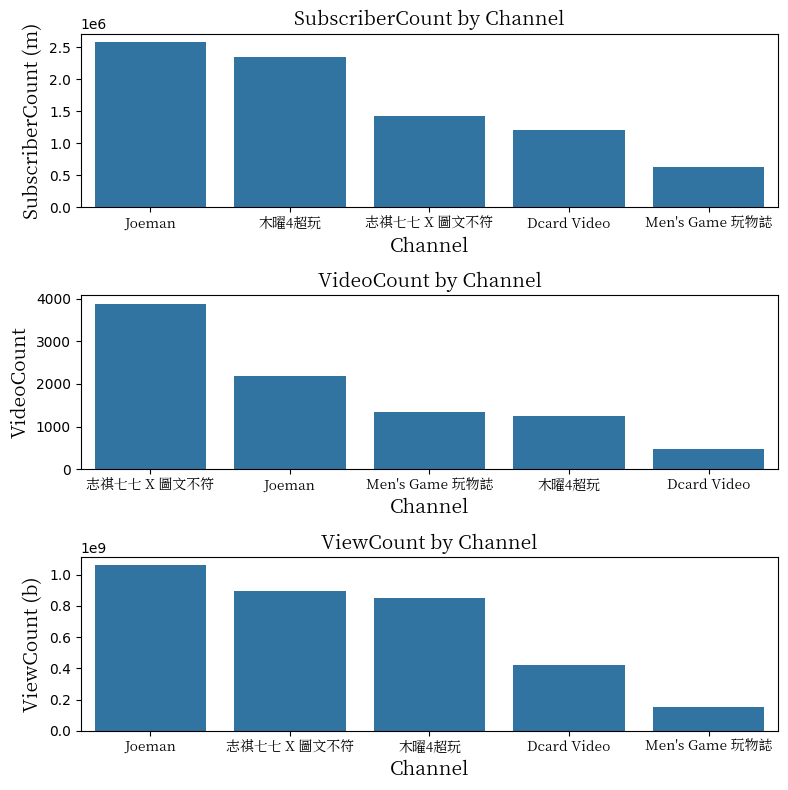

In [19]:
from matplotlib.font_manager import FontProperties

# 設定字型
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

# 設定figure大小及圖形數量
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 8))

# 繪圖及設定圖標題，軸標籤，字型及刻度
data = channel_df.sort_values(by='subscriberCount', ascending=False)
sns.barplot(data, x='channel_title', y='subscriberCount', estimator='sum', errorbar=None, ax=axs[0])
axs[0].set_title('SubscriberCount by Channel', fontproperties=font, fontsize=14)
axs[0].set_ylabel('SubscriberCount (m)', fontproperties=font, fontsize=14)

data = channel_df.sort_values(by='videoCount', ascending=False)
sns.barplot(data, x='channel_title', y='videoCount', estimator='sum', errorbar=None, ax=axs[1])
axs[1].set_title('VideoCount by Channel', fontproperties=font, fontsize=14)
axs[1].set_ylabel('VideoCount', fontproperties=font, fontsize=14)

data = channel_df.sort_values(by='viewCount', ascending=False)
sns.barplot(data, x='channel_title', y='viewCount', estimator='sum', errorbar=None, ax=axs[2])
axs[2].set_title('ViewCount by Channel', fontproperties=font, fontsize=14)
axs[2].set_ylabel('ViewCount (b)', fontproperties=font, fontsize=14)

for ax in axs:
  ax.set_xlabel('Channel', fontproperties=font, fontsize=14)
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font, rotation=0, fontsize=10)

# 用於多個子圖時，自動調整布局，避免子圖之間或子圖與標籤重疊
plt.tight_layout()

# 儲存圖片並顯示
plt.savefig("長條圖01.png", dpi=200)
plt.show()

分析資料期間：由頻道成立起至2024年4月27日

概覽頻道的幾個宏觀指標（以下指標皆由大至小排序，數字為約略數）：
* 總訂閱數前三：Joeman（258萬），木曜4超玩（234萬），志祺七七X圖文不符（142萬）
* 總影片數前三：志祺七七X圖文不符（3,891支），Joeman（2,193支），Men's Game 玩物誌（1,353支）
* 總觀看數前三：Joeman（10億6千萬次），志祺七七X圖文不符（8億9千萬次），木曜4超玩（8億4千萬次）

上圖發現 "志祺七七X圖文不符" 頻道最晚成立，然而可能因發布影片數最多，使得總觀看數位居第2，總訂閱數位居第3。

### 8-2 每月平均觀看數

此部分觀察各頻道影片於每月的平均觀看數，以了解影片觀看情形隨時間的變化。這裡不選擇觀察較短的時間周期（如每日，每周），因為資料點會太密集而造成趨勢變化觀察不易。

補充：因為無法取得影片隨時間演進的觀看數變化，因此我們假設每支影片的觀看數的主要貢獻是集中在影片上傳後的一個月內，以方便了解觀看數的趨勢變化。

In [14]:
# 提取年份和月份並組成新的欄位 'published_year_month'
year_month_df = pd.DataFrame()
year_month_df['year'] = video_df['published_at'].dt.year
year_month_df['month'] = video_df['published_at'].dt.month
video_df['published_year_month'] = pd.to_datetime(year_month_df[['year', 'month']].assign(DAY=1))

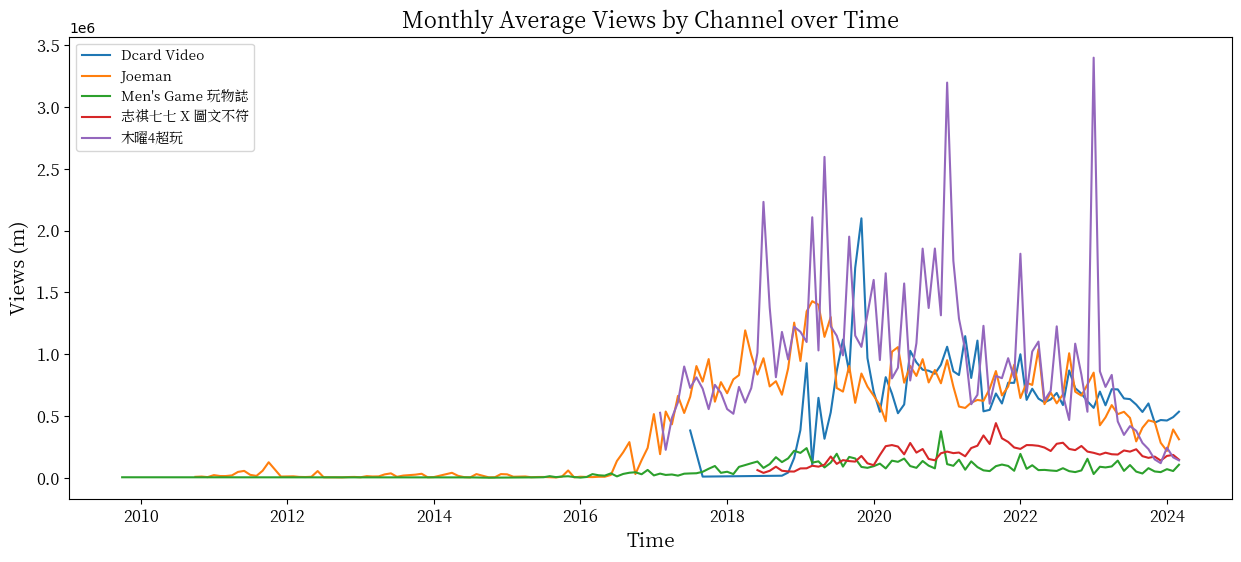

In [17]:
from matplotlib.font_manager import FontProperties

# 設定字型
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

# 設定figure大小
plt.figure(figsize=(15,6))

# 繪圖
data = video_df.groupby(['channel_title', 'published_year_month'])['view_count'].mean().reset_index()
sns.lineplot(data, x='published_year_month', y='view_count', hue='channel_title', estimator='sum', errorbar=None)

# 設定圖標題，軸標籤，字型及刻度
plt.title('Monthly Average Views by Channel over Time', fontproperties=font, fontsize=16)
plt.xlabel('Time', fontproperties=font, fontsize=14)
plt.ylabel('Views (m)', fontproperties=font, fontsize=14)
plt.xticks(fontproperties=font, rotation=0, fontsize=12)
plt.yticks(fontproperties=font, rotation=0, fontsize=12)

# 設定圖例
plt.legend(prop=font)

# 儲存圖片並顯示
plt.savefig("折線圖02.png", dpi=200)
plt.show()

分析資料期間：由頻道成立起至2024年4月27日

上圖可發現2016年以前僅有兩個頻道存在，且觀看數變化不大，因此下面針對2016年以後的資料進行分析

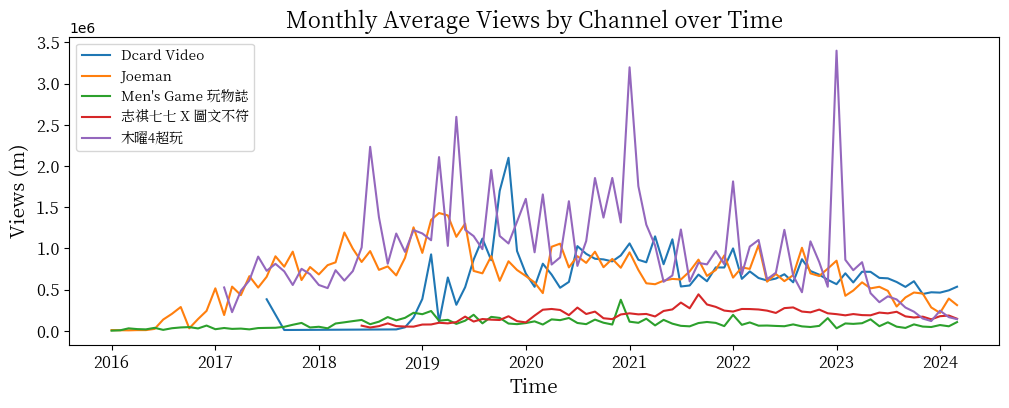

In [18]:
from matplotlib.font_manager import FontProperties

# 設定字型
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

# 設定figure大小
plt.figure(figsize=(12,4))

# 繪圖
data = video_df[video_df['published_at']>='2016-01-01'].reset_index(drop=True)
data = data.groupby(['channel_title', 'published_year_month'])['view_count'].mean().reset_index()
sns.lineplot(data, x='published_year_month', y='view_count', hue='channel_title', estimator='sum', errorbar=None)

# 設定圖標題，軸標籤，字型及刻度
plt.title('Monthly Average Views by Channel over Time', fontproperties=font, fontsize=16)
plt.xlabel('Time', fontproperties=font, fontsize=14)
plt.ylabel('Views (m)', fontproperties=font, fontsize=14)
plt.xticks(fontproperties=font, rotation=0, fontsize=12)
plt.yticks(fontproperties=font, rotation=0, fontsize=12)

# 設定圖例
plt.legend(prop=font)

# 儲存圖片並顯示
plt.savefig("折線圖03.png", dpi=200)
plt.show()

分析資料期間：2016年1月1日至2024年4月27日

觀察每月平均觀看：
* "木曜4超玩"：2023年以前落在100萬以上
* "Joeman" 及 "Dcard Video"：2020至2023年間，約落在50萬至100萬
* "志祺七七X圖文不符" 及 "Men's Game 玩物誌"：約落在50萬以下

2023年以後，多數頻道的觀看數皆呈現下降趨勢，可能原因為近年自媒體盛行使得Youtube平台的越趨競爭，而導致流量紅利逐漸變小。

### 8-3 觀眾互動程度
觀察"影片得到觀眾按讚的比率"及"影片得到觀眾留言的比率"，以了解不同頻道下，觀眾與頻道主的互動程度。

建立指標：
* like_per_view(%)：Number of Likes / Number of Views * 100
* comment_per_view(%)：Number of Comments / Number of Views * 100

In [20]:
# 創建欄位
video_df['like_per_view(%)'] = video_df['like_count']/video_df['view_count']*100
video_df['comment_per_view(%)'] = video_df['comment_count']/video_df['view_count']*100

<ipython-input-21-0d791f6e1d8c>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font, rotation=0, fontsize=10)


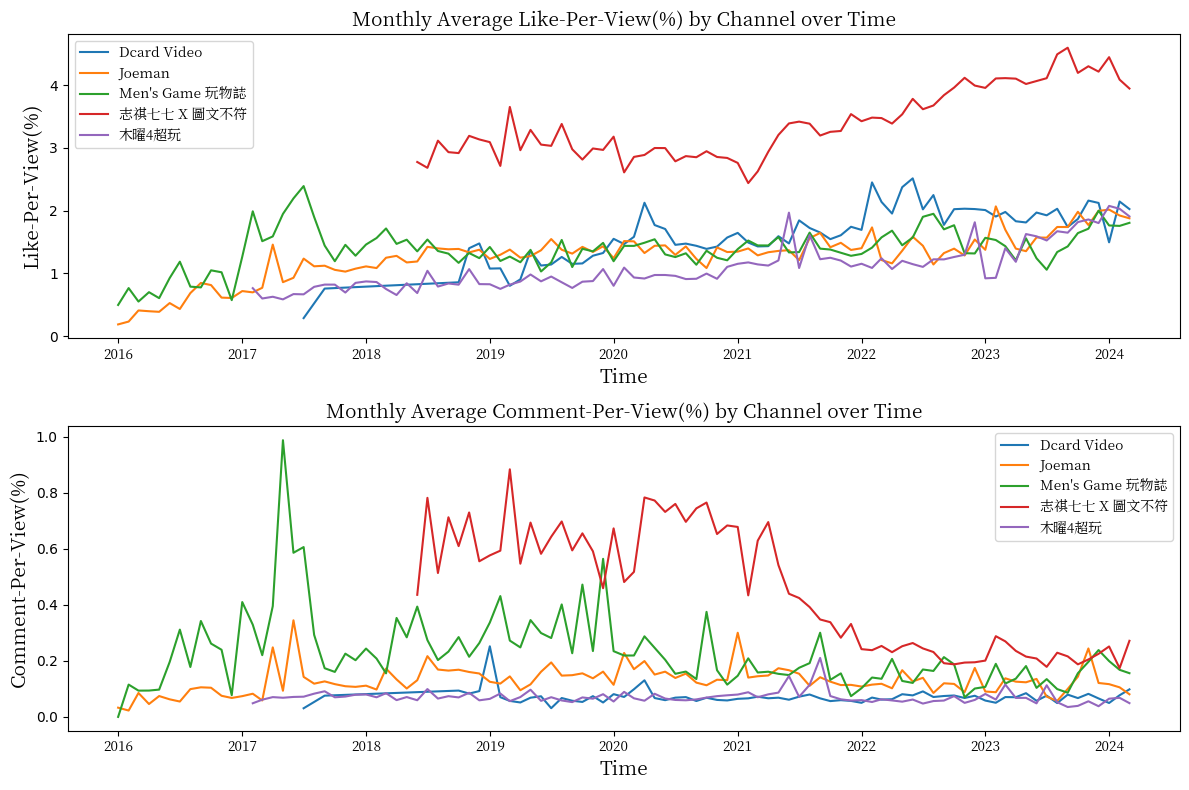

In [21]:
from matplotlib.font_manager import FontProperties

# 設定字型
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

# 設定figure大小及圖形數量
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# 繪圖及設定圖標題，軸標籤，字型，刻度及圖例
data = video_df[video_df['published_at']>='2016-01-01'].reset_index(drop=True)
data = data.groupby(['channel_title', 'published_year_month'])['like_per_view(%)'].mean().reset_index()
sns.lineplot(data, x='published_year_month', y='like_per_view(%)', hue='channel_title', estimator='sum', errorbar=None, ax=axs[0])
axs[0].set_title('Monthly Average Like-Per-View(%) by Channel over Time', fontproperties=font, fontsize=14)
axs[0].set_ylabel('Like-Per-View(%)', fontproperties=font, fontsize=14)

data = video_df[video_df['published_at']>='2016-01-01'].reset_index(drop=True)
data = data.groupby(['channel_title', 'published_year_month'])['comment_per_view(%)'].mean().reset_index()
sns.lineplot(data, x='published_year_month', y='comment_per_view(%)', hue='channel_title', estimator='sum', errorbar=None, ax=axs[1])
axs[1].set_title('Monthly Average Comment-Per-View(%) by Channel over Time', fontproperties=font, fontsize=14)
axs[1].set_ylabel('Comment-Per-View(%)', fontproperties=font, fontsize=14)

for ax in axs:
  ax.set_xlabel('Time', fontproperties=font, fontsize=14)
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font, rotation=0, fontsize=10)
  ax.legend(prop=font)

# 用於多個子圖時，自動調整布局，避免子圖之間或子圖與標籤重疊
plt.tight_layout()

# 儲存圖片並顯示
plt.savefig("折線圖04.png", dpi=200)
plt.show()

分析資料期間：2016年1月1日至2024年4月27日

觀察每月平均按讚比例及留言比例：
* "志祺七七X圖文不符" 相較其他4個頻道的按讚比例明顯較高，且隨時間呈上升趨勢；而留言比例亦相較其他4個頻道來得高，但隨時間呈下降趨勢。（可能原因請見下一節：每月發布影片數及影片平均長度）

* "Men's Game 玩物誌" 的留言比例在2018年後持續位於前段第2，查看發現頻道主較常回應觀眾留言。此外，在2017年5月份有較高比例的留言數，查看發現當月份有支抽獎活動的影片帶動起後續幾日其他影片留言數的居高

### 8-4 每月發布影片數及影片平均長度

了解不同頻道的發片頻率及長短影片策略對觀看情形的可能影響也非常重要，有助於調整優化發布策略以吸引留存目標觀眾。

In [22]:
# 選取所需資料並按照"頻道"及"發布年月"進行分組，接著計算每月發布影片數及影片平均長度
data = video_df[video_df['published_at']>='2016-01-01'].reset_index(drop=True)
month_average_videoCount = data.groupby(['channel_title', 'published_year_month'])['video_id'].count().reset_index().rename(columns = {'video_id': 'videoCount'})
month_average_videoDuration = data.groupby(['channel_title', 'published_year_month'])['video_duration_minutes'].mean().reset_index().rename(columns = {'video_duration_minutes': 'avg_duration(mins)'})

<ipython-input-23-d61a8cddc4fc>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font, rotation=0, fontsize=10)


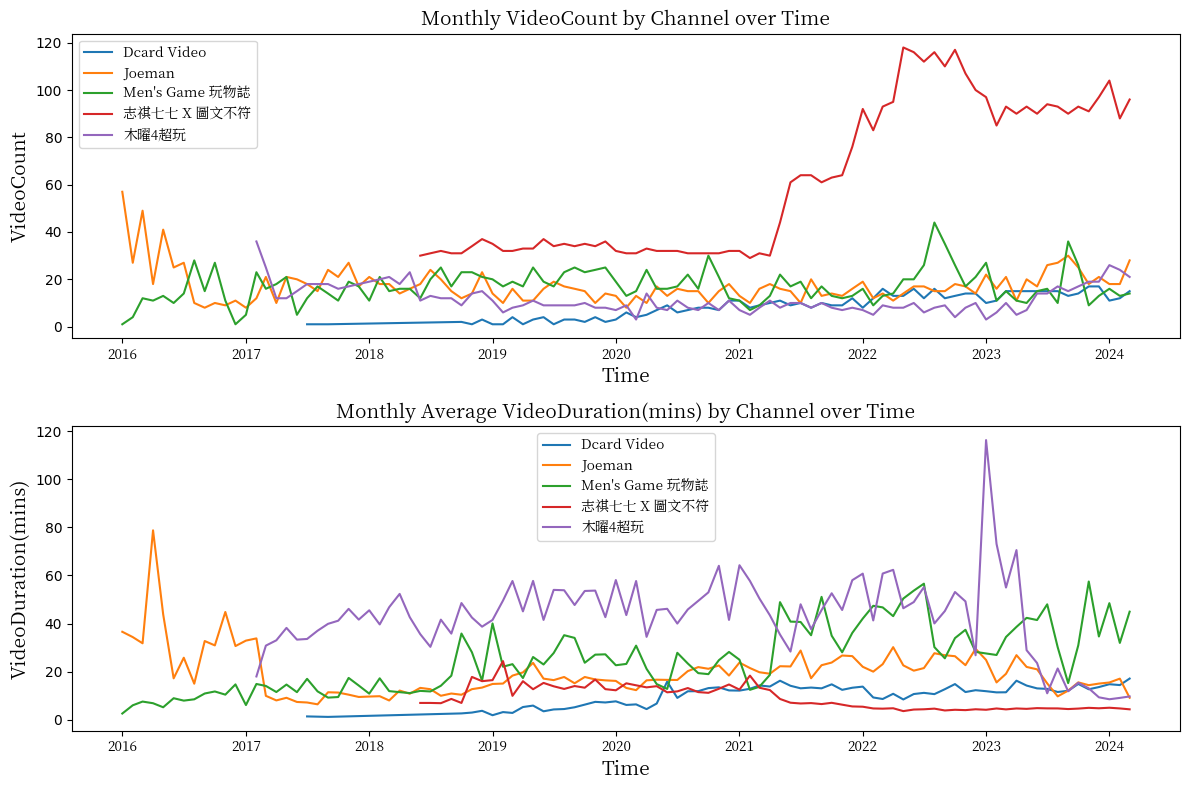

In [23]:
from matplotlib.font_manager import FontProperties

# 設定字型
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

# 設定figure大小及圖形數量
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# 繪圖及設定圖標題，軸標籤，字型，刻度及圖例
sns.lineplot(month_average_videoCount, x='published_year_month', y='videoCount', hue='channel_title', estimator='sum', errorbar=None, ax=axs[0])
axs[0].set_title('Monthly VideoCount by Channel over Time', fontproperties=font, fontsize=14)
axs[0].set_ylabel('VideoCount', fontproperties=font, fontsize=14)

sns.lineplot(month_average_videoDuration, x='published_year_month', y='avg_duration(mins)', hue='channel_title', estimator='sum', errorbar=None, ax=axs[1])
axs[1].set_title('Monthly Average VideoDuration(mins) by Channel over Time', fontproperties=font, fontsize=14)
axs[1].set_ylabel('VideoDuration(mins)', fontproperties=font, fontsize=14)

for ax in axs:
  ax.set_xlabel('Time', fontproperties=font, fontsize=14)
  ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font, rotation=0, fontsize=10)
  ax.legend(prop=font)

# 用於多個子圖時，自動調整布局，避免子圖之間或子圖與標籤重疊
plt.tight_layout()

# 儲存圖片並顯示
plt.savefig("折線圖05.png", dpi=200)
plt.show()

分析資料期間：2016年1月1日至2024年4月27日

觀察每月發布影片數：
* "志祺七七X圖文不符" 一開始是每月發布約30支影片，自2021年5月開始錄製短影音shorts而提升到每月約60支影片，自2022年1月以後則提升到90支，可能為造成上述按讚比例及留言比例有明顯變化的原因
* 除 "志祺七七X圖文不符" 以外的4個頻道，每月發布影片數平均都落在30支以下

觀察每月發布影片平均長度：
* "木曜4超玩" 在2022年11月以前皆發布長影片居多，2022年11月以後開始發布較多shorts短影片，可能是造成上述每月平均觀看數在2023年以後逐漸下降的原因，也說明它原本的主要觀眾應是較喜歡長影片內容的觀眾群，因此建議該頻道保持主打一貫的長影片風格，應能較好的發揮優勢，改善其下降的觀看數
* "志祺七七X圖文不符" 及 "Dcard Video" 的影片多數落在20分鐘以內，可能說明兩者皆嚴格執行特定的影片長度策略



下面進一步查看所有頻道的影片，比較影片時間小於2分鐘及超過2分鐘，分別在按讚比例及留言比例上的差別，發現短影音確實更容易取得讚數，但較不會獲得觀眾留言。

In [24]:
# 不分頻道，查看影片時間小於2分鐘及超過2分鐘，分別在按讚比例及留言比例上的差別
shorter = video_df[video_df['video_duration_minutes']<=2][["like_per_view(%)", "comment_per_view(%)"]].mean()
print(f"【影片時間小於2分鐘】\n{shorter}\n")
longer = video_df[video_df['video_duration_minutes']>2][["like_per_view(%)", "comment_per_view(%)"]].mean()
print(f"【影片時間超過2分鐘】\n{longer}")

【影片時間小於2分鐘】
like_per_view(%)       3.949954
comment_per_view(%)    0.139125
dtype: float64

【影片時間超過2分鐘】
like_per_view(%)       1.523522
comment_per_view(%)    0.252191
dtype: float64


### 8-5 影片發布時間

透過影片發布時間可了解各頻道是否考慮了觀眾看YT影片的時間習慣，或是僅僅只是按照上班時的工作習慣進行影片發布。

In [25]:
# 創建欄位
video_df['published_date'] = video_df['published_at'].dt.date
video_df['published_at(hr)'] = video_df['published_at'].dt.hour

In [26]:
# 計算各個發布時間(Date-Hour)的影片數
data = video_df[video_df['published_at']>='2016-01-01'].reset_index(drop=True)
published_videoCount = data.groupby(['channel_title', 'published_date', 'published_at(hr)'])['video_id'].count().reset_index().rename(columns = {'video_id': 'videoCount'})

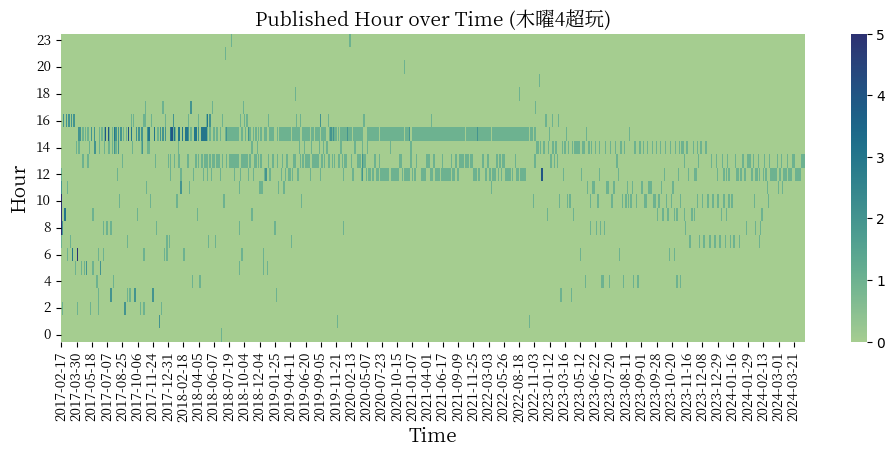

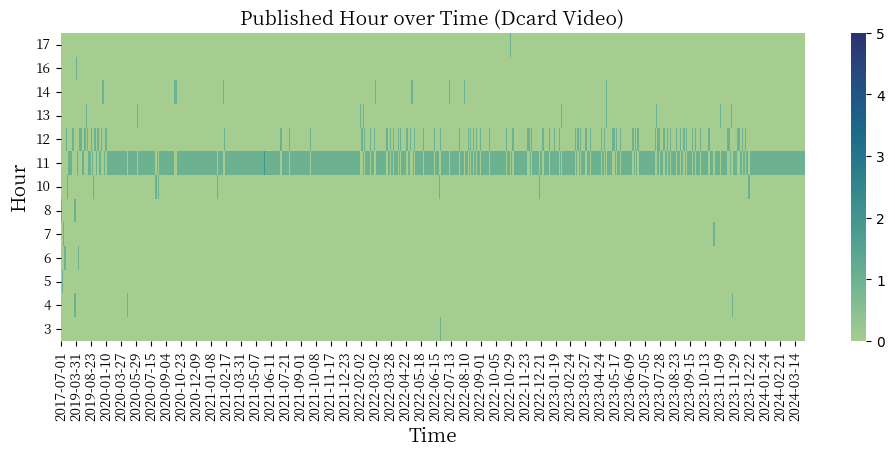

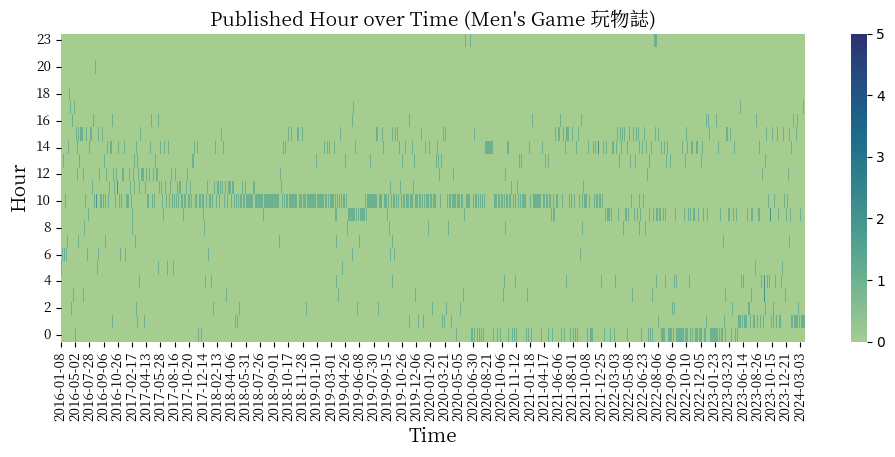

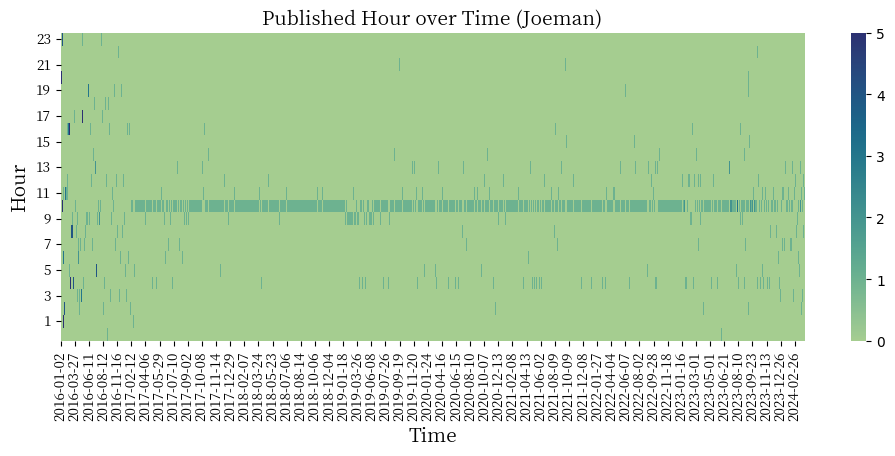

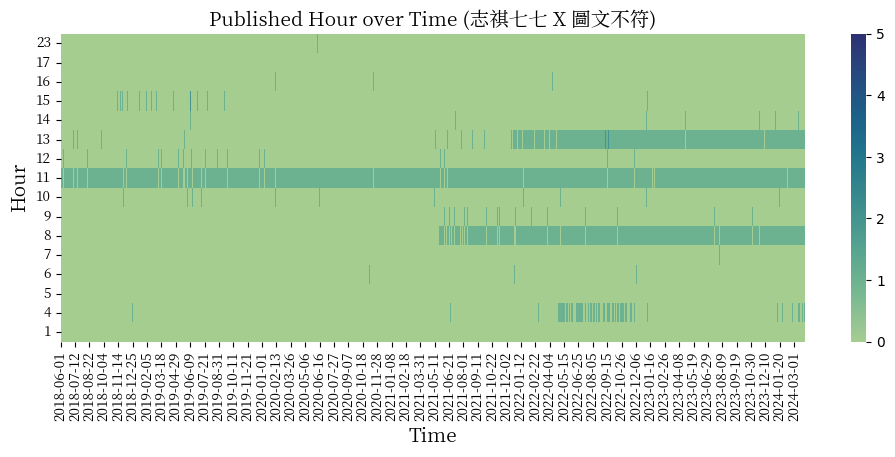

In [30]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

def make_heatmap(data, channel_title):
  # 設定figure大小
  plt.figure(figsize=(12,4))

  # 繪圖
  data = data[data['channel_title']==channel_title].pivot_table(values='videoCount', index='published_at(hr)', columns='published_date', aggfunc="sum", fill_value=0)
  data = data.reindex(index=data.index[::-1])
  sns.heatmap(data, cmap="crest", vmax=5)

  # 設定圖標題，軸標籤，字型及刻度
  plt.title(f"Published Hour over Time ({channel_title})", fontproperties=font, fontsize=14)
  plt.xlabel('Time', fontproperties=font, fontsize=14)
  plt.ylabel('Hour', fontproperties=font, fontsize=14)
  plt.xticks(fontproperties=font, rotation=90, fontsize=10)
  plt.yticks(fontproperties=font, rotation=0, fontsize=10)

  # 顯示圖片
  plt.show()

channel_titles = ['木曜4超玩', 'Dcard Video', "Men's Game 玩物誌", 'Joeman', '志祺七七 X 圖文不符']
for channel_title in channel_titles:
  make_heatmap(published_videoCount, channel_title)

分析資料期間：2016年1月1日至2024年4月27日

觀察影片發布時間：
* "木曜4超玩" 在2022年11月以前主要集中在中午12點至15點，2022年11月以後則較不固定，大概是因為該時間點以後多了短影片，拍攝所需時間較短，能較隨意發布
* "Dcard Video" 及 "Joeman" 主要集中在早上10點至12點發布影片，判斷兩者應該都是提前錄製好影片，因此皆設定好固定上片的時間
* "Men's Game 玩物誌" 在2022年8月以後有一部分集中在凌晨12點至1點，推測有可能想吸引海外的觀眾
* "志祺七七X圖文不符" 集中在早上8,11,13點，查看發現該頻道每日約上傳2支短影片及1支一般影片

整體來說，發布時間多數落在白天10點至15點，而若對照每月平均觀看數來看，或許嚴格遵守同一時間的發布是個可行的策略。



### 8-6 影片最常設定的標籤（Tags）

標籤的設定有其重要性，通常是影片的關鍵字，能幫助觀眾尋找特定的影片內容，以提升點閱率。此外，下面透過分析各頻道不同時期所設定的前10名標籤，可了解影片主題類型的變化趨勢。


In [31]:
# 創建欄位
video_df['published_year'] = video_df['published_at'].dt.year

In [32]:
import ast
import numpy as np

# 定義一個函數來安全地應用 ast.literal_eval
def safe_literal_eval(x):
  """
  去除外面的字串，取得裡面的列表
  """
  try:
    return ast.literal_eval(x)
  except (SyntaxError, ValueError):
    return np.nan

# 去除video_tags欄位的字串，取得裡面的列表
video_df['tags'] = video_df['video_tags'].apply(safe_literal_eval)

In [33]:
def most_used_tags_by_year(data, channel_title, n_tags):
  # 選取所需資料，並將tags欄位中每列的列表拆開變成多列
  selected = data[(data['channel_title'] == channel_title)]
  all_tags = selected.explode('tags').groupby(['published_year', 'tags']).size().reset_index(name='tag_count')
  all_tags = all_tags[all_tags['tags']!='yt:cc=on'].reset_index(drop=True)

  # 找出每個年份下，前n名使用數的tags
  top_tags = all_tags.groupby('published_year').apply(lambda x: x.nlargest(n_tags, 'tag_count')).reset_index(drop=True)

  # 將資料轉換成pivot table
  pivot_table = top_tags.pivot_table(index=top_tags.groupby('published_year').cumcount()+1, columns='published_year', values='tags', aggfunc='first')

  print(f"Top {n_tags} Tags by Year ({channel_title})")
  return pivot_table

In [34]:
# 列出每個頻道前n名使用數的tags
channel_titles = ['木曜4超玩', 'Dcard Video', "Men's Game 玩物誌", 'Joeman', '志祺七七 X 圖文不符']
for channel_title in channel_titles:
  display(most_used_tags_by_year(video_df, channel_title, n_tags = 10))
  print('\n')

Top 10 Tags by Year (木曜4超玩)


published_year,2017,2018,2019,2020,2021,2022,2023,2024
1,邰智源,一日系列,一日系列,energy,energy,energy,energy,energy
2,泱泱,木曜4超玩,木曜4超玩,一日系列,一日系列,一日系列,一日系列,一日系列
3,溫妮,泱泱,泱泱,坤達,坤達,坤達,坤達,上班去吃飯
4,木曜4超玩,溫妮,溫妮,木曜4超玩,小黑,小黑,木曜4超玩,下班去吃飯
5,一日系列,綜藝節目,邰智源,泱泱,木曜4超玩,木曜4超玩,木耀,丘涵
6,吳宗憲,邰智源,坤達,溫妮,木耀,木耀,木要,全明星運動大會
7,玩很大,林柏昇KID,energy,邰智源,木要,木要,林柏昇KID,坤達
8,大熱門,LuLu,林柏昇KID,林柏昇KID,林柏昇KID,林柏昇KID,泱泱,木曜4超玩
9,林柏昇KID,吳宗憲,綜藝節目,綜藝節目,泱泱,泱泱,溫妮,木曜家廚房
10,LuLu,大熱門,琳來瘋,阿部瑪利亞,溫妮,溫妮,瑪麗亞,木耀




Top 10 Tags by Year (Dcard Video)


published_year,2017,2018,2019,2020,2021,2022,2023,2024
1,DCARD,dcard,街訪,Dcard,Dcard,Dcard,Dcard,IG
2,一年,Dcard,校訪,Dcard調查局,Dcard調查局,dcard,文章,女生
3,女孩,D雞精新聞,dcard,街訪,Dcard尋奇,街訪,精選,男生
4,牙齒矯正,dcard調查局,Dcard,校訪,低卡,Dcard調查局,尋奇,社群
5,秘密,公益,dcard調查局,Dcard尋奇,感情,低卡,街訪,CK
6,NaN,台科大,Dcard調查局,哈哈台,街訪,調查局,dcard,Dcard
7,NaN,小事公益,大學生,大學生,校訪,Dcard尋奇,女友,EMO
8,NaN,小事公益七天挑戰賽,哈哈台,洋蔥,Joeman,感情,日本,PINKFUN
9,NaN,有趣板,鬧大學,年輕人,上班不要看,分手,穿搭,Reels
10,NaN,校園採訪,世新大學,戀愛,女友,尋奇,追星,instagram




Top 10 Tags by Year (Men's Game 玩物誌)


published_year,2009,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
1,ANA飛機併飛,wilier,rx100m4,dji,dji,game,game,game,game,game,game,game
2,NaN,roadbike,sony,drone,mavic,men's,men's,men's,men's,men's,men's,men's
3,NaN,公路車,fdrax100,phantom,roadbike,iphone,iphone,iphone,Three Kingdom Tactics,S4,Joeman,日本
4,NaN,18禁,roadbike,roadbike,phantom,apple,apple,apple,三国志战略版,Three Kingdom Tactics,養老,買房
5,NaN,GoPro,公路車,gopro,youtuber,review,台灣人行大陸,手機,開箱,三国志战略版,10萬,3Ctim
6,NaN,gopro,Sony Corporation (Computer Manufacturer/Brand),無人機,specialized,travel,旅遊,美食,武將,攻城,Tim哥,Joeman
7,NaN,hero,specialized,vlog,vlog,開箱,中國,台灣,評比,武將,侯友宜,Tim哥
8,NaN,specialized,wilier,公路車,camera,iphone x,美食,android,露營,第五賽季,動保,iPhone
9,NaN,彭于晏,gopro,specialized,apple,美食,大陸,旅遊,review,第四賽季,摩肯dr. save,大阪
10,NaN,成人,Photography (Visual Art Form),空拍機,iphone,蘋果,自助行,開箱,攻城,開荒,摩肯dr. save抽真空機評價,房價




Top 10 Tags by Year (Joeman)


published_year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
1,RP,joeman,justin.tv,joeman,joeman,joeman,dota,joeman,MAZDA,BMW,BMW,BMW,BMW,BMW,BMW
2,RTS,starcraft,joeman,justin.tv,羅密歐,攻略,joeman,九妹,joeman,MAZDA,MAZDA,MAZDA,SUV,MAZDA,MAZDA
3,joeman,星海爭霸,starcraft,twitch,JOEMAN,刀塔傳奇,legend,實況,九妹,SUV,SUV,SUV,TOYOTA,SUV,SUV
4,starcraft,RTS,joemanstarcraft,明星,暴雪英霸,秘技,starcraft,搞笑,實況,TOYOTA,TOYOTA,TOYOTA,joeman,TOYOTA,TOYOTA
5,starcraft2,RP,gaming,海峽,刀塔傳奇,實況,talk,直播,德國,joeman,joeman,joeman,lifestyle,joeman,joeman
6,starcraftII,starcraft2,RP,sobad,攻略,刀塔,九妹,精華,搞笑,lifestyle,lifestyle,lifestyle,九妹,lifestyle,lifestyle
7,中文,starcraftII,RTS,兩岸,星海,直播,刀塔,綜藝,日本,九妹,九妹,九妹,實況,九妹,九妹
8,對戰,中文,starcraft2,微星,CONM,密技,刀塔傳奇,遊戲,直播,實況,實況,實況,房車,實況,實況
9,星海爭霸,對戰,starcraftII,台灣,sobad,星海,密技,電玩,精華,德國,德國,德國,搞笑,德國,德國
10,華語,華語,中文,戰車世界,密技,搞笑,實況,電競,綜藝,房車,房車,房車,旅遊,房車,房車




Top 10 Tags by Year (志祺七七 X 圖文不符)


published_year,2018,2019,2020,2021,2022,2023,2024
1,圖文不符,志祺七七,武漢肺炎,中國,中國,中國,日本
2,志祺,張志祺,新聞回顧,日本,日本,日本,中國
3,志祺七七,志祺,國際新聞,美國,疫情,世界紀錄,211餐盤
4,時事,圖文不符,台灣新聞,台灣,美國,獵奇,外食族
5,知識,時事,韓國瑜,奧運,烏俄戰爭,美國,外食減重學
6,生活,生活,川普,辱華,俄羅斯,職場,宋晏仁醫師
7,社會議題,知識,歷史,疫情,台灣,AI,志祺七七減重法
8,資訊設計,社會議題,每週新聞,韓國,英國,荒謬,美國
9,張志祺,資訊設計,新聞,疫苗,職場,NAT,荷爾蒙體質
10,簡訊設計,簡訊設計,溫馨新聞,志祺,辱華,nat,危險


分析資料期間：由頻道成立起至2024年4月27日

觀察影片最常設定的標籤：
* "木曜4超玩" 常設標籤可以看出該頻道主要的常態性參與人及常見的影片系列，像是"一日系列" 及 "下班去吃飯" 等
* "Dcard Video" 主要透過街訪，校訪的方式討論有關男女生，大學生的話題，而常見的影片系列如"Dcard尋奇"，"Dcard調查局"等
* "Men's Game 玩物誌" 該頻道從早期介紹公路車，科技3C，遊戲，到後來拍攝旅遊，開箱，養老等話題
* "Joeman 常設標籤包含遊戲，實況，汽車等，但該頻道實際上在過去也有許多3C的開箱影片，以及系列影片如"Joe是要對決"，這部分皆沒出現在標籤中，判斷應是頻道主沒有設定該類標籤，因此建議可增加相關標籤，方便觀眾更好找到相關影片
* "志祺七七X圖文不符" 主要探討時事新聞，國際議題，另外可看出近年所使用的標籤文字更加具體

### 8-7 觀看數最多的影片標題

從觀看數最多的影片中可了解標題如何設定較能夠吸引觀眾眼球，進而提升點擊率。因此，下面我們找出各頻道最多觀看數的前10名影片。

In [35]:
# 篩選出每個頻道前n名觀看數的影片
top_videos = video_df[['channel_title', 'video_title', 'view_count']].\
          sort_values(by=['channel_title', 'view_count'], ascending=[True, False]).\
          groupby('channel_title').head(10)

# 調整呈現方式
pivot_df = top_videos.set_index(['channel_title', top_videos.groupby('channel_title').cumcount()+1]).unstack(level=0)
pivot_df

video_title  \
channel_title                                        Dcard Video   
1              明星喬裝潛入校園會被發現嗎？【音癡 vs 天籟美聲頂尖對決！】特別企劃 Feat.🎤神隱少女...   
2              30歲存不到10萬可以嗎？年輕人VS長輩看法交鋒！理財已經退流行了，散財才是正解？【30歲存...   
3              8+9女友都好正，原來是夠壞夠有錢？沒有很可以，但你惹不起！【 校園8+9大搜查！】致理科技...   
4              幫扣安全帽、約看螢火蟲、喝醉時送上膝枕！受訪者現場的曖昧直球～調查局這次要當媒人了！？【曖昧...   
5              暈船花了三年才戒掉？頻繁私訊、各種親密接觸！來看看暈船仔是如何被養套殺！【 暈船患者集中營】...   
6              (ENG / 한글자막 SUB )巧遇舒華啊啊啊｜愛追星的女友｜如何取綽號 @officia...   
7                            買鞋買到20萬？一餐只花35塊？【敗家VS節儉大對決】台北商業大學校訪   
8              抖M男興起！女生講髒話、開黃腔也可以很加分？【理想女友大公開】台灣海洋大學校訪 | Dcar...   
9                          【有錢人 VS 平民大對決！】 I 信義區街訪 I Dcard 調查局 🧐   
10                           最花心的星座是前男友？星座運勢只挑好的看？【星座刻板印象】桃園銘傳校訪   

                                                                  \
channel_title                                             Joeman   
1               【Joeman Show Ep18】獨家揭密！老高與小茉的愛情故事！ft.老高 Kuaizero   
2                            【Joeman Show Ep29】史上最貴！開箱台灣首富郭台銘的家！   
3                              【Joeman】如果人生24小時都被17直播監視！？(ft.咪妃)   
4                 【Joeman Show Ep4】矛盾對決！吃不飽的大胃王vs吃到飽的高級牛排店！ft.路路   
5              【Joeman】1000元的頂級便當對決50元的平價便當！ft.柯文哲【Joe是要對決】SP...   
6                                【Joeman】長榮皇璽桂冠艙體驗！在飛機上吃龍蝦！(商務艙)   
7                  【Joeman】開價兩億的新莊豪宅！貧窮限制我的想像！遠雄九五《Joe是要看房》 ep.3   
8              【Joeman】直逼頭等艙的豪華配置！大韓航空商務艙體驗！Korean Air A380 B...   
9                                  【Joeman】實測！網路上徵打字賺外快的廣告原來是詐騙？   
10             【Joeman】在飛機上吃鴨胸！華航A350-900商務艙體驗！China Airlines...   

                                                                  \
channel_title                                     Men's Game 玩物誌   
1              體驗火龍功直接用火燒 沐雨柔 @evemu716 的背 火療福利時間 「Men's Game...   
2              [ENG Sub]全是假貨？蘋果Apple iPhone 山寨大本營 Airpods好便宜 ...   
3              這樣子住更便宜！ 大草皮 組合屋vs  貨櫃屋 竟然比我家還要高級 不買房EP05「Men'...   
4              [ ENG Sub ] 我不用iPhone了 這 N 個理由告訴你為什麼我叛逃到androi...   
5                不孝？你能接受送父母親去養老院嗎？體驗養老生活 ft.長庚養生村「Men's Game玩物誌」   
6              被吃軟飯老公推入當酒店小姐！後來如何脫離酒店轉戰YouTube ? 今天誰上車EP04 @e...   
7              開箱華強北山寨 AirPods vs 原廠正品 誰比較強大？假貨真貨怎麼分？耳機iPhone...   
8                     開飲料店能賺錢嗎？ 不是客人越多越賺錢！「Men's Game玩物誌」#shorts   
9              防疫自己用電動理髮器推頭髮很省錢 | 油頭髮型必備 | 德國百靈BRAUN HC5030電動...   
10             會黃標啦！怕癢的不要來 腳底按摩按起來 看美腿的都去罰站啦 ft.沐雨柔 愛美教主 @eve...   

                                                                  \
channel_title                                        志祺七七 X 圖文不符   
1                 🇨🇳中國外交部發言人＃趙立堅 出包辱華！原因竟然是......？😅｜志祺七七 #shorts   
2                        🎤 中共百年生日，習近平：中國沒有欺壓過別人！💢｜志祺七七   #shorts   
3                🤦🏻‍♂️現代版「大意失荊州」！中國斥資上億的 #關公銅像 遭拆除🪓｜志祺七七 #shorts   
4                            日本餐廳拒接中國客😲祭出「64符咒」超有用😲｜志祺七七 #shorts   
5                           奧運網球女雙落敗，台灣觀眾還嘲笑狂酸？「詹家姐妹」為何被討厭？｜志祺七七   
6                           外國玩家改裝「金正恩痛車」，結果竟然慘遭⋯⋯！｜志祺七七 #shorts   
7              你知道這是什麼嗎？ 亞馬遜電商Ellen到底是誰？這真的是詐騙嗎？《YouTube 觀察日記...   
8                             🇹🇼中國＝西台灣？這麼直接辱華真的好嗎？！｜志祺七七 #shorts   
9              【 志祺七七 】《逃犯條例》到底有多可怕？為何讓百萬香港人不顧一切也要上街阻擋？《左邊鄰居觀...   
10                           🎊太神啦！北市小四學生，讓全校不用寫作業！👏｜志祺七七 #shorts   

                                                                  view_count  \
channel_title                                              木曜4超玩 Dcard Video   
1              《一日系列第六十九集》最強主管～市長柯P來了！邰哥來挑戰史上最崩潰工作！-一日市長幕僚fea...     3308830   
2              2020第二屆YARTIST全明星運動大會!新世代-集結!團結就是力量!Ft.這群人.千千....     3030908   
3              《一日系列第一百集》喜鴻假期來了!!邰導遊帶木曜全體工作人員暢玩北海道!!-一日北海道導遊(...     2921581   
4              2021第三屆YARTIST全明星運動大會-無論輸贏！拚盡全力！Ft.這群人.視網膜.眼肉芽...     2578762   
5              2019第一屆YARTIST全明星運動大會!!全部人都給我動起來!! Feat.白癡公主.阿...     2337082   
6              2022第四屆YARTIST全明星運動大會-突破逆境！飛越稜線！Ft.Fischer's這群...     2327431   
7              《木曜家民宿3-宜蘭篇(上)》我誰!!!狠愛演帶著六萬人團隊來入住木曜家民宿啦!!〔一日系列...     2288197   
8              你說什麼廠商？！這次濃縮再濃縮，實境再實境！feat.蔡哥、泡泡、蟲蟲學姊【一個屋簷下】(新... 

分析資料期間：由頻道成立起至2024年4月27日

分析觀看數最多的影片標題：
* "Dcard Video" 標題主要與存款，8+9女友好正，暈船，消費習慣等文字有關，其中有將近半數的影片都有使用對比不同群體的文字（如敗家&節儉，有錢人&平民），而有明星客串在內的影片佔了2部
* "Joeman" 前5名的影片都有網紅或知名人物的客串（如老高，郭台銘），而飛機搭乘體驗佔了3部，對決高檔與平價系列的影片則佔了2部
* "Men's Game 玩物誌" 有女網紅客串的影片佔據第1，另外有提到IPhone的文字也較為熱門。此外，也有用到具對比意思的文字（組合屋vs貨櫃屋，山寨vs正品）
* "志祺七七X圖文不符" 標題主要是跟兩岸議題，國際議題，新聞時事有關，其中shorts短影音竟佔了7部，說明該頻道的shorts影片可能相較一般影片來得更吸引觀眾
* "木曜4超玩" 前6名的影片主要是包含影片系列的文字，如"一日系列"，"全明星運動會"等。此外，該頻道有兩部破千萬觀看的影片皆有相關知名人物的客串

整體來說，除"志祺七七X圖文不符"以外的4個頻道，第一名的影片皆有網紅或知名人物客串在內。此外，對比類型的影片標題也是獲得高觀看數的可能原因。

### 8-8 影片標題及影片說明的字數 & 標籤使用數量

最後查看各頻道對於與影片內容有關的文字設定是否遵循特定規律。

In [36]:
# 創建欄位
video_df['video_title_length'] = video_df['video_title'].apply(lambda x: len(x))
video_df['video_description_length'] = video_df['video_description'].apply(lambda x: len(x) if not pd.isna([x]).all() else 0)
video_df['tags_count'] = video_df['tags'].apply(lambda x: len(x) if not pd.isna([x]).all() else 0)

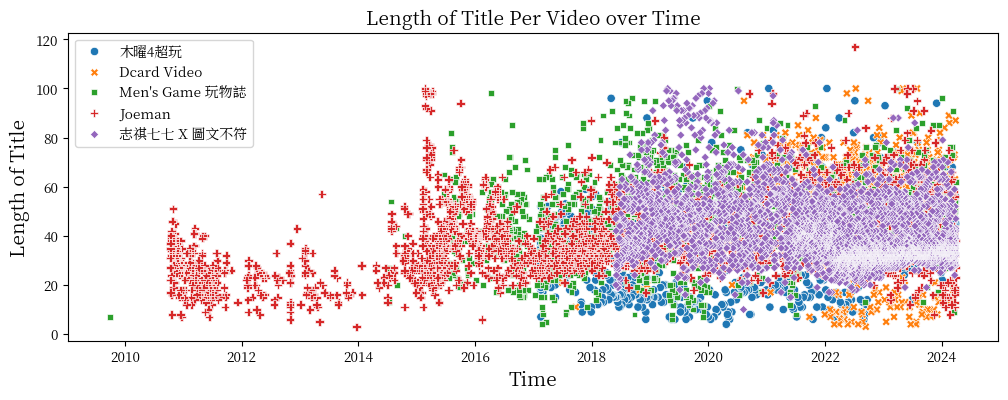

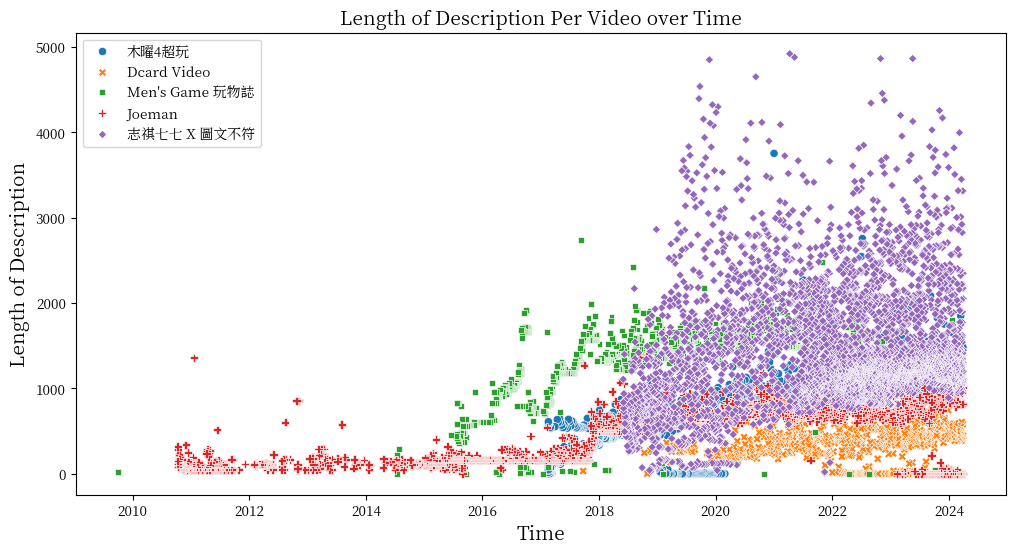

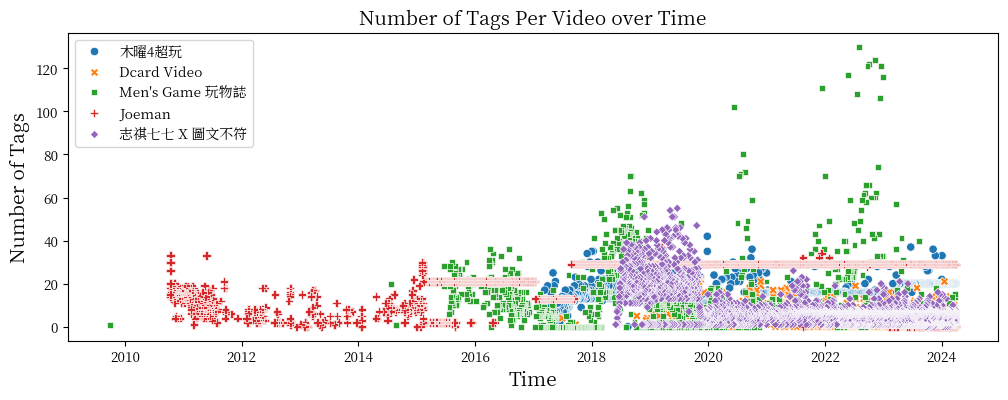

In [37]:
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="/content/drive/MyDrive/Colab Notebooks/Chinese_Font/Noto_Serif_TC/NotoSerifTC-Regular.otf")

def make_scatter(data, feature, figsize, plt_title, plt_ylabel):
  # 設定figure大小
  plt.figure(figsize=figsize)

  # 繪圖
  sns.scatterplot(video_df, x='published_date', y=feature, hue='channel_title', style="channel_title")

  # 設定圖標題，軸標籤，字型及刻度
  plt.title(plt_title, fontproperties=font, fontsize=14)
  plt.xlabel('Time', fontproperties=font, fontsize=14)
  plt.ylabel(plt_ylabel, fontproperties=font, fontsize=14)
  plt.xticks(fontproperties=font, rotation=0, fontsize=10)
  plt.yticks(fontproperties=font, rotation=0, fontsize=10)

  # 設定圖例
  plt.legend(prop=font)

  # 顯示圖片
  plt.show()

features = ['video_title_length', 'video_description_length', 'tags_count']
figsize = [(12,4), (12,6), (12,4)]
plt_titles = ["Length of Title Per Video over Time", "Length of Description Per Video over Time", "Number of Tags Per Video over Time"]
plt_ylabels = ["Length of Title", "Length of Description", "Number of Tags"]
for ind, feature in enumerate(features):
  make_scatter(video_df, feature, figsize[ind], plt_titles[ind], plt_ylabels[ind])


分析資料期間：由頻道成立起至2024年4月27日

觀察影片標題的字數：
* 無發現特定規律

觀察影片說明的字數：
* "志祺七七X圖文不符" 相較其他4個頻道所使用的影片說明字數來的多，查看發現該頻道在說明區裡放的內容涵蓋了製作團隊，影片分節內容，參考資料及相關連結等較詳盡的資料

觀察影片使用的標籤數量：
* "Joeman" 在2019年以後使用標籤的數量幾乎都是29個，對照上述"影片最常設定的標籤"章節，確實觀察到在該年以後的標籤使用幾乎沒變，說明該頻道主應是已不太在意標籤的設定及使用數量
* "Dcard Video" 是所有頻道中最不常使用標籤的

整體而言，並無觀察到各頻道對於上述三個部分有特定的設定規律。

## 9.結論

* 為了解臺灣知名 Youtube 頻道的經營策略及表現，因此透過 API 取得 5 個頻道的資料，並使用 Python 分析頻道訂閱數，影片數，觀看數，觀眾互動程度，影片發布策略，影片文字設定策略等，以了解各頻道間的差異，並提供相關決策建議，期望提升影片點擊率及吸引目標用戶
* 2023 年以後，多數頻道的月平均觀看數皆呈現下降趨勢，可能是近年自媒體盛行使得 Youtube 平台的越趨競爭，而導致流量紅利逐漸變小
* 分析所有頻道的影片，發現短影音更容易取得讚數，但較少獲得觀眾留言
* "志祺七七X圖文不符" 及 "Dcard Video" 的影片多數落在20分鐘以內，可能說明兩者皆嚴格執行特定的影片長度策略
* 除"志祺七七X圖文不符"以外的4個頻道，各自觀看數第一名的影片皆有網紅或知名人物客串在內。此外，對比類型的影片標題也是獲得高觀看數的可能原因

## 10.建議

* "木曜4超玩" 在2022年11月以前皆發布長影片居多，2022年11月以後開始發布較多shorts短影片，可能是造成上述每月平均觀看數在2023年以後逐漸下降的原因，也說明它原本的主要觀眾應是較喜歡長影片內容的觀眾群，因此建議該頻道保持主打一貫的長影片風格，應能較好的發揮優勢，改善其下降的觀看數

* "Joeman" 頻道內容中有許多3C的開箱影片，以及系列影片如"Joe是要對決"，這部分皆沒出現在標籤中，因此建議可增加上述類型標籤，方便觀眾更好找到相關影片


## 11.參考資料

* [新創如何與 YouTuber 合作，借助他們的影響力](https://appworks.tw/startup-youtuber-marketing/)
* [YouTube Data API (v3) - Quota Calculator](https://developers.google.com/youtube/v3/determine_quota_cost)
* [Youtube行銷怎麼做？最新Youtube行銷策略和短影音分析看這裡](https://twfirst.com.tw/digital-marketing/youtube-marketing/)
* [如何提升 YouTube 點閱率？YouTube 標籤是什麼？為什麼很重要？](https://tw.cyberlink.com/blog/youtube-video-editing/543/youtube-seo)
* [台灣YouTube頻道訂閱人數排行榜](https://zh.wikipedia.org/wiki/%E5%8F%B0%E7%81%A3YouTube%E9%A0%BB%E9%81%93%E8%A8%82%E9%96%B1%E4%BA%BA%E6%95%B8%E6%8E%92%E8%A1%8C%E6%A6%9C)
* [訂閱人數最多的YouTube頻道](https://zh.wikipedia.org/wiki/%E8%AE%A2%E9%98%85%E4%BA%BA%E6%95%B0%E6%9C%80%E5%A4%9A%E7%9A%84YouTube%E9%A2%91%E9%81%93)